In [5]:
import torch
if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.5 MB/s 
     |████████████████████████████████| 7.6 MB 31.0 MB/s 
     |████████████████████████████████| 182 kB 43.2 MB/s 


In [6]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/classifier.csv")

print('Overview of Dataset')

df.sample(10)

Overview of Dataset


,Summaries,medical_specialty
442,This 69-year-old man is undergoing a preoperat...,Cardiovascular / Pulmonary
138,"Hemiarthroplasty, right hip. Fracture of the r...",Discharge Summary
510,Bronchoscopy with bronchoalveolar lavage. Refr...,Cardiovascular / Pulmonary
180,This 34-year-old gentleman awoke this morning ...,Dermatology
329,Cervical spondylosis and kyphotic deformity. T...,Consult - History and Phy.
49,Right argon laser assisted stapedectomy. Bilat...,ENT - Otolaryngology
356,Aortic valve replacement. Assessment of stenot...,Cardiovascular / Pulmonary
173,"Skin biopsy, scalp mole. A 66-year-old female ...",Dermatology
355,Insertion of a right brachial artery arterial ...,Cardiovascular / Pulmonary
32,Laparoscopic hand-assisted left adrenalectomy ...,Gastroenterology


In [7]:
df['medical_specialty'].value_counts()

 Cardiovascular / Pulmonary    180
 Consult - History and Phy.    128
 Discharge Summary              52
 ENT - Otolaryngology           47
 Gastroenterology               37
 Emergency Room Reports         24
 Dermatology                    18
 Dentistry                      18
 Cosmetic / Plastic Surgery     15
 Endocrinology                  10
 Bariatrics                      5
 Diets and Nutritions            3
 Allergy / Immunology            2
Name: medical_specialty, dtype: int64

In [9]:
#choose top 5 classes with most datapoints
# This is done to ensure some sort of balance between classes
df = df[df['medical_specialty'].isin([' Cardiovascular / Pulmonary',' Consult - History and Phy.',' Discharge Summary',' ENT - Otolaryngology',' Gastroenterology'])]

In [10]:
df['medical_specialty'].value_counts()

 Cardiovascular / Pulmonary    180
 Consult - History and Phy.    128
 Discharge Summary              52
 ENT - Otolaryngology           47
 Gastroenterology               37
Name: medical_specialty, dtype: int64

<ipython-input-11-3076d9d4276c>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_ylabel('')


Text(0, 0.5, '')

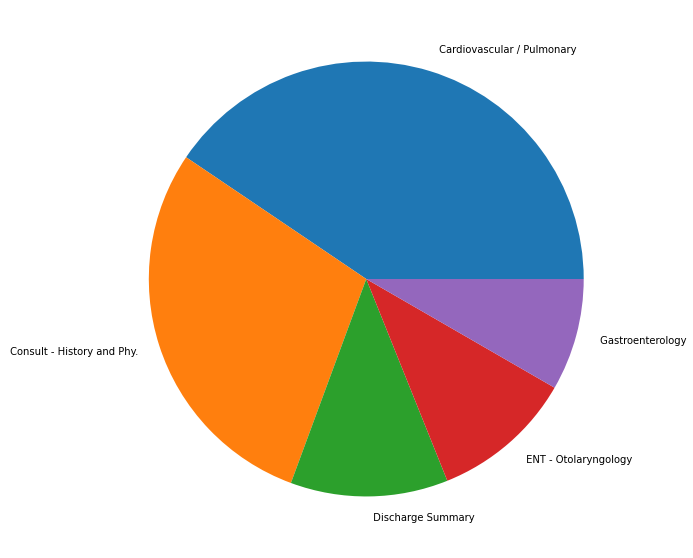

In [11]:
#distribution of chosen classes
import matplotlib.pyplot as plt
plot = df.medical_specialty.value_counts().plot.pie(y='Chilll', figsize=(10, 10))
plt.axes().set_ylabel('')

In [12]:
sentences = df.Summaries.values
labels = df.medical_specialty.values

In [13]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
labels= label_encoder.fit_transform(labels)

In [14]:
from sklearn.model_selection import train_test_split

sentences, sentences_test, labels, labels_test = train_test_split(sentences,labels,test_size = 0.2)

In [14]:
#choose tokenizer depending upon the model
from transformers import BertTokenizer,RobertaTokenizer,ElectraTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
# tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [16]:
max_length = 0
for sent in sentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_length = max(max_length, len(input_ids))

In [17]:
def dataPreProcessing(input_ids,attention_masks,labels,sentences,tokenizer):
  input_ids = []
  attention_masks = []

  for val in sentences:
      encodings = tokenizer.encode_plus(
                          val,                      
                          add_special_tokens = True, 
                          max_length = 64,           
                          pad_to_max_length = True,
                          return_attention_mask = True,   
                          return_tensors = 'pt',     
                    )
        
      input_ids.append(encodings['input_ids'])
      attention_masks.append(encodings['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  return input_ids,attention_masks,labels

In [18]:
input_ids = []
attention_masks = []

input_ids,attention_masks,labels = dataPreProcessing(input_ids,attention_masks,labels,sentences,tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
from torch.utils.data import TensorDataset, random_split

data = TensorDataset(input_ids, attention_masks, labels)

train_num = int(0.9 * len(data))
val_num = len(data) - train_num

train_data, val_data = random_split(data, [train_num, val_num])

In [20]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

val_loader = DataLoader(
            val_data, 
            sampler = SequentialSampler(val_data), 
            batch_size = batch_size 
        )

train_loader = DataLoader(
            train_data,  
            sampler = RandomSampler(train_data), 
            batch_size = batch_size 
        )




In [21]:
import torch
torch.cuda.empty_cache()

In [9]:
from transformers import BertForSequenceClassification, AdamW, BertConfig,RobertaForSequenceClassification, ElectraForSequenceClassification

# Choose model according to requirement

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 5, 
)

# model = BertForSequenceClassification.from_pretrained(
#     "bert-large-uncased", 
#     num_labels = 5, 
# )

# model = RobertaForSequenceClassification.from_pretrained(
#     "roberta-large", 
#     num_labels = 5, 
# )

# model = RobertaForSequenceClassification.from_pretrained(
#     "roberta-base", 
#     num_labels = 5, 
# )

# model = ElectraForSequenceClassification.from_pretrained(
#     "google/electra-small-discriminator", 
#     num_labels = 5, 
# )


model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [24]:
from transformers import get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )


epochs = 15
trainSteps = epochs * len(train_loader)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = trainSteps)

In [25]:
import numpy as np

def cal_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [26]:
import time
import datetime

def get_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [28]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_loader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits
        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)            
    
    training_time = get_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_loader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        

        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += cal_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(val_loader)
    
    validation_time = get_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(get_time(time.time()-total_t0)))


======== Epoch 1 / 15 ========
Training...

  Average training loss: 1.21
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.45
  Validation Loss: 1.36
  Validation took: 0:00:00

======== Epoch 2 / 15 ========
Training...

  Average training loss: 1.14
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.62
  Validation Loss: 1.24
  Validation took: 0:00:00

======== Epoch 3 / 15 ========
Training...

  Average training loss: 1.03
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.64
  Validation Loss: 1.15
  Validation took: 0:00:00

======== Epoch 4 / 15 ========
Training...

  Average training loss: 0.91
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.67
  Validation Loss: 1.01
  Validation took: 0:00:00

======== Epoch 5 / 15 ========
Training...

  Average training loss: 0.84
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.69
  Validation Loss: 1.08
  Validation took: 0:00:00

======== Epoch

In [29]:
sentences = sentences_test
labels = labels_test

input_ids = []
attention_masks = []

input_ids,attention_masks,labels = dataPreProcessing(input_ids,attention_masks,labels,sentences,tokenizer)
# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
predict_data = TensorDataset(input_ids, attention_masks, labels)
predict_sampler = SequentialSampler(predict_data)
prediction_loader = DataLoader(predict_data, sampler=predict_sampler, batch_size=batch_size)

In [ ]:


print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

model.eval()


predictions , true_labels = [], []


for batch in prediction_loader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  logits = logits.detach().cpu().numpy()
  pred_labels = np.argmax(logits, axis=1)
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.extend(pred_labels.tolist())
  true_labels.extend(label_ids.tolist())

print('Predictions Completed')

In [33]:
from sklearn.metrics import classification_report

results= classification_report(true_labels, predictions, digits=4)
print(results)

              precision    recall  f1-score   support

           0     0.8372    0.8780    0.8571        41
           1     0.7600    0.7600    0.7600        25
           2     0.2000    0.1429    0.1667         7
           3     0.5556    0.7143    0.6250         7
           4     0.7143    0.5556    0.6250         9

    accuracy                         0.7416        89
   macro avg     0.6134    0.6101    0.6068        89
weighted avg     0.7308    0.7416    0.7338        89



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#References
#https://mccormickml.com/2019/07/22/BERT-fine-tuning/
#https://huggingface.co/docs/transformers/v4.24.0/en/model_doc/electra
#https://huggingface.co/docs/transformers/v4.24.0/en/model_doc/roberta
#https://huggingface.co/docs/transformers/v4.24.0/en/model_doc/bert